## Part 1:

Gather the dataset of hubNashville requests from https://data.nashville.gov/Public-Services/hubNashville-311-Service-Requests/7qhx-rexh. For this project, you should look at requests with Request Type of "COVID-19" and Subrequest Type of "COVID-19 Violations". Explore this dataset, looking at when and where these violations occurred.



In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import folium
import shapely.geometry

In [2]:
#getting data from API, case_requests = COVID-19 and setting limit to 25k

url = 'https://data.nashville.gov/resource/7qhx-rexh.json?case_request=COVID-19&$limit=25000'

response = requests.get(url)

In [3]:
#reading the json text to dataframe

hubNashville = pd.read_json(response.text)

In [4]:
#subsetting for case_requests and case_subrequest

hubNashville = hubNashville[hubNashville['case_subrequest'] == 'COVID-19 Violations']

In [5]:
#converting open and close to datetime

hubNashville['date_time_opened'] = [pd.to_datetime(d) for d in hubNashville['date_time_opened']]
hubNashville['date_time_closed'] = [pd.to_datetime(d) for d in hubNashville['date_time_closed']]

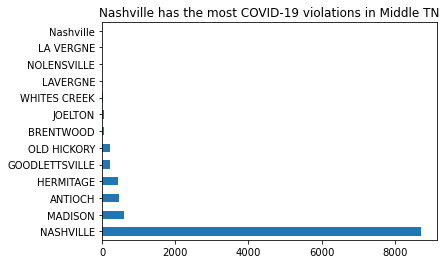

In [6]:
hubNashville['incident_city'].value_counts().plot(kind='barh', 
                                                  title='Nashville has the most COVID-19 violations in Middle TN');

Nashville leads the number of violations with ____

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


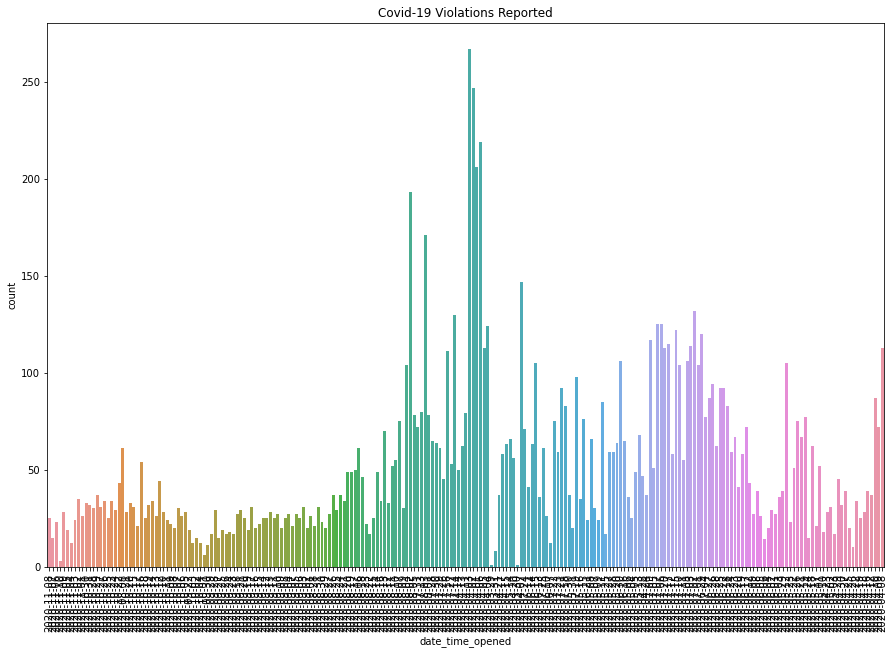

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
data = hubNashville['date_time_opened'].dt.strftime('%Y-%m-%d')
sns.countplot(data)
plt.xticks(rotation='vertical')
plt.title('Covid-19 Violations Reported');

In [8]:
#creating new column with value_counts
hubNashville['opened_year_month_date'] = hubNashville['date_time_opened'].dt.strftime('%Y-%m-%d')

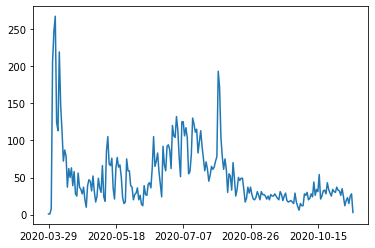

In [9]:
hubNashville['opened_year_month_date'].value_counts().sort_index().plot();

In [10]:
violations_by_day = hubNashville.groupby('opened_year_month_date').size().to_frame('count')
violations_by_day

,count
opened_year_month_date,
2020-03-29,1
2020-03-30,1
2020-03-31,8
2020-04-01,206
2020-04-02,247
...,...
2020-11-06,23
2020-11-07,15
2020-11-08,25


## Part 2:
The file davidson_cases.csv contains the number of COVID cases in Davidson county per day from March 8 through October 29. Use this dataset to compare the trend for the number of cases over time to the number of reported violations. Feel free to add any additional data that you think might be useful.

In [11]:
davidsonco_cases = pd.read_csv('../data/davidson_cases.csv')
davidsonco_cases.head()

,date,county,state,fips,cases,deaths
0,2020-03-08,Davidson,Tennessee,47037,1,0
1,2020-03-09,Davidson,Tennessee,47037,1,0
2,2020-03-10,Davidson,Tennessee,47037,1,0
3,2020-03-11,Davidson,Tennessee,47037,2,0
4,2020-03-12,Davidson,Tennessee,47037,6,0


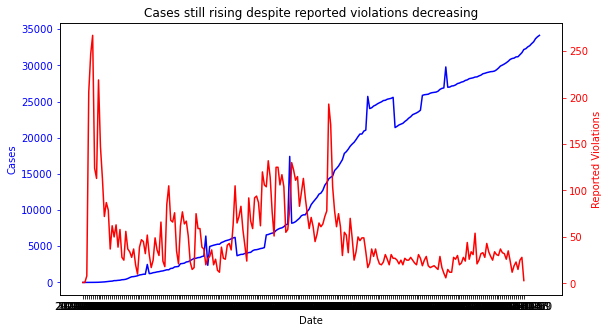

In [12]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(davidsonco_cases['date'], davidsonco_cases['cases'], 
           color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Cases', color='blue')
ax.tick_params('y', colors='blue')
ax2 = ax.twinx()
ax2.plot(violations_by_day.index, violations_by_day['count'],          
         color='red')
ax2.set_ylabel('Reported Violations', color='red')
ax2.tick_params('y', colors='red')
plt.title('Cases still rising despite reported violations decreasing');

## Part 3:
The Metro Public Health Department tracks COVID-19 clusters. The files clusters.csv and clusters_by_type.csv contain the tables of clusters as reported by WSMV along with the coordinates of the clusters. Can you find any connection between the reported COVID violations and subsequent COVID clusters?

In [30]:
clusters = pd.read_csv('../data/clusters_revised.csv')

In [14]:
clusters_by_type = pd.read_csv('../data/clusters_by_type.csv')
clusters_by_type

,Cluster Type,Number of Clusters
0,Bar,7
1,Church,2
2,College / University,5
3,Commercial-Warehouse,12
4,Congregate Living,13
5,Construction,19
6,Correctional Facility,9
7,Day Care,7
8,Food Production,2
9,Grocery,1


In [15]:
violations_clusters = pd.merge(hubNashville, clusters, left_on=['latitude', 'longitude'], 
                                         right_on=['Latitude', 'Longitude'])

In [16]:
#assigning unnecessary columns
cols = ['case_request', 'case_subrequest', 'additional_subrequest', 'state_issue', 'closed_when_created', 'contact_type','parent_case', 'Latitude', 'Longitude']

#dropping unnecessary columns
violations_clusters = violations_clusters.drop(columns=cols, axis=1)

In [17]:
violations_clusters.head()

,case_number,status,date_time_opened,date_time_closed,case_origin,incident_address,latitude,longitude,mapped_location,incident_city,incident_council_district,incident_zip_code,opened_year_month_date,Cluster Name,Facility Type,Cluster Start Date,# Cases
0,498041,Closed,2020-11-09 04:44:05,2020-11-09 16:48:56,hubNashville Community,207 Printers Alley,36.164369,-86.778515,"{'latitude': '36.164369', 'longitude': '-86.77...",NASHVILLE,19.0,37201.0,2020-11-09,Miss Kelli's,Bar,10/1/2020,14
1,487902,Closed,2020-10-25 04:22:34,2020-10-26 14:37:35,hubNashville Community,207 Printers Alley,36.164369,-86.778515,"{'latitude': '36.164369', 'longitude': '-86.77...",NASHVILLE,19.0,37201.0,2020-10-25,Miss Kelli's,Bar,10/1/2020,14
2,482950,Closed,2020-10-18 04:24:54,2020-10-19 16:03:15,hubNashville Community,207 Printers Alley,36.164369,-86.778515,"{'latitude': '36.164369', 'longitude': '-86.77...",NASHVILLE,19.0,37201.0,2020-10-18,Miss Kelli's,Bar,10/1/2020,14
3,471299,Closed,2020-09-26 18:30:59,2020-09-28 16:30:16,hubNashville Community,207 Printers Alley,36.164369,-86.778515,"{'latitude': '36.164369', 'longitude': '-86.77...",NASHVILLE,19.0,37201.0,2020-09-26,Miss Kelli's,Bar,10/1/2020,14
4,391515,Closed,2020-06-13 04:43:17,2020-06-15 15:32:01,hubNashville Community,207 Printers Alley,36.164369,-86.778515,"{'latitude': '36.164369', 'longitude': '-86.77...",NASHVILLE,19.0,37201.0,2020-06-13,Miss Kelli's,Bar,10/1/2020,14


In [22]:
#dropping observations with null values in latitude or longitude
violations_clusters = violations_clusters.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)

In [23]:
violations_clusters.sort_values('date_time_opened')

,case_number,status,date_time_opened,date_time_closed,case_origin,incident_address,latitude,longitude,mapped_location,incident_city,incident_council_district,incident_zip_code,opened_year_month_date,Cluster Name,Facility Type,Cluster Start Date,# Cases
20,339963,Closed,2020-04-06 14:14:51,2020-04-14 15:27:29,hubNashville Community,2201 West End Ave,36.144703,-86.802655,"{'latitude': '36.1447034', 'longitude': '-86.8...",NASHVILLE,18.0,37240.0,2020-04-06,Vanderbilt Parties,Social Gathering,3/11/2020,49
21,340492,Closed,2020-04-06 18:40:51,2020-04-13 16:13:15,hubNashville Community,10 Lea Ave,36.157460,-86.769873,"{'latitude': '36.1574605', 'longitude': '-86.7...",NASHVILLE,19.0,37210.0,2020-04-06,Rolling Mill Hill job site,Construction,6/3/2020,21
18,360510,Closed,2020-05-06 15:57:32,2020-05-07 15:08:02,hubNashville Community,422 Broadway,36.160769,-86.778210,"{'latitude': '36.1607689', 'longitude': '-86.7...",NASHVILLE,19.0,37203.0,2020-05-06,Tootsie's,Bar,6/26/2020,27
4,391515,Closed,2020-06-13 04:43:17,2020-06-15 15:32:01,hubNashville Community,207 Printers Alley,36.164369,-86.778515,"{'latitude': '36.164369', 'longitude': '-86.77...",NASHVILLE,19.0,37201.0,2020-06-13,Miss Kelli's,Bar,10/1/2020,14
8,391726,Closed,2020-06-14 06:20:53,2020-06-15 15:30:46,hubNashville Community,1911 Division St,36.149673,-86.796748,"{'latitude': '36.149673', 'longitude': '-86.79...",NASHVILLE,19.0,37203.0,2020-06-14,Loser's,Bar,6/26/2020,29
17,391810,Closed,2020-06-14 18:46:01,2020-06-15 15:39:12,hubNashville Community,422 Broadway,36.160769,-86.778210,"{'latitude': '36.1607689', 'longitude': '-86.7...",NASHVILLE,19.0,37203.0,2020-06-14,Tootsie's,Bar,6/26/2020,27
15,395923,Closed,2020-06-19 00:10:04,2020-06-19 18:23:42,hubNashville Community,210 Anne Dallas Dudley Blvd,36.160769,-86.778210,"{'latitude': '36.1607689', 'longitude': '-86.7...",NASHVILLE,19.0,37219.0,2020-06-19,Tootsie's,Bar,6/26/2020,27
16,397007,Closed,2020-06-20 17:30:13,2020-06-22 16:25:04,hubNashville Community,422 Broadway,36.160769,-86.778210,"{'latitude': '36.1607689', 'longitude': '-86.7...",NASHVILLE,19.0,37203.0,2020-06-20,Tootsie's,Bar,6/26/2020,27
13,400409,Closed,2020-06-25 15:37:14,2020-06-26 16:48:04,Phone,422 Broadway,36.160769,-86.778210,"{'latitude': '36.1607689', 'longitude': '-86.7...",NASHVILLE,19.0,37203.0,2020-06-25,Tootsie's,Bar,6/26/2020,27
14,401058,Closed,2020-06-25 23:29:33,2020-06-26 16:48:17,hubNashville Community,422 Broadway,36.160769,-86.778210,"{'latitude': '36.1607689', 'longitude': '-86.7...",NASHVILLE,19.0,37203.0,2020-06-25,Tootsie's,Bar,6/26/2020,27
